Paper: [Growing Neural Gas Network Learns 
Topologies](https://papers.nips.cc/paper/1994/file/d56b9fc4b0f1be8871f5e1c40c0067e7-Paper.pdf)

In [161]:
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython import display
import matplotlib.animation as animation
from time import perf_counter

np.random.seed(8770)

In [162]:
img_name = "data-3"

In [163]:
data_path = os.path.join("GNG_data", f"{img_name}.png")
img = plt.imread(data_path)

In [164]:
binary_img = img[:, :, 0]
np.unique(binary_img)

array([0., 1.], dtype=float32)

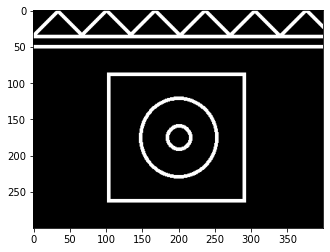

In [165]:
fig, ax = plt.subplots()
ax.imshow(binary_img, cmap="gray")
plt.show()

## Image

In [155]:
# img_name = "the_columns"
# img_name = "DerekAnderson"
img_name = "Derek-Anderson-3"

In [156]:
from skimage import img_as_float, color, io, exposure
from skimage.filters import gaussian
from skimage.filters import threshold_otsu

In [157]:
def preprocess_image(img_name, save=False):
    data_path = os.path.join("GNG_data", f"{img_name}.jpg")
    img = io.imread(data_path)
    img = img_as_float(img)
    img = color.rgb2gray(img)
    # img = exposure.equalize_adapthist(img, clip_limit=0.03)
    img = gaussian(img, sigma=0.6)
    
    otsu_th = 0
    inverse = False
    
    if img_name == "DerekAnderson":
        img = img[0:280, 60:250]
        otsu_th = -0.1
        inverse = True
    elif img_name == "the_columns":
#         img = img[60:, :]
#         img[0:25, 0:40] = 0
        otsu_th = 0.1
    elif img_name =="Derek-Anderson-3":
        img[-120:, 0:100] = 1
        otsu_th = -0.1
        inverse = True
    
    thresh = threshold_otsu(img_gray_blur) + otsu_th
    img = img > thresh
    if inverse:
        img = np.invert(img)
    return img

In [158]:
binary_img = preprocess_image(img_name, save=False)

In [159]:
# io.imsave(f"{img_name}-gray.png", img_gray)
# # io.imsave(f"{img_name}-adapteq.png", img_adapteq)
# io.imsave(f"{img_name}-gray_blur.png", img_gray_blur)
# io.imsave(f"{img_name}-binary.png", binary_img)

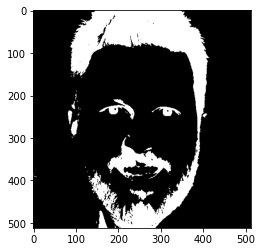

In [160]:
fig, ax = plt.subplots()
ax.imshow(binary_img, cmap="gray")
plt.show()

Nodes
- A set $A$ of nodes.
- Each node $c \in A$ has an associated *reference vector* $\vec{w}_c \in \mathbb{R}^{n}$ which is the position of the node in the input space.

Connections
- A set $N$ of edges.
- Connections are not weighted.
- Define the topological structure of a GNG network.

In [166]:
data = np.argwhere(binary_img > 0)
data.shape, binary_img.shape

((12432, 2), (300, 400))

## GNG Algorithm

0. Start with two nodes, $a$ and $b$ at random positions $\vec{w}_a, \vec{w}_b \in \mathbb{R}^{n}$
1. Generate an input signal $\beta$ according to $P(\beta)$
2. Find the nearest node $s_1$ and the second nearest node $s_2$
3. Increment the age of all edges emanating from $s_1$

In [167]:
def generate_input_signal(data):
    return data[np.random.choice(data.shape[0])]

In [168]:
histories = {}

In [169]:
class GrowingNeuralGas():
    def __init__(self, step=0.1, step_neighbor=0.01, max_age=100, time_add_node=1000, alpha=0.5, d=0.95, max_iteration=500, max_node=100):
        self.nodes = {}
        self.step = step
        self.step_neighbor = step_neighbor
        self.max_age = max_age
        self.time_add_node = time_add_node
        self.iteration = 0
        self.alpha = alpha
        self.d = d
        self.max_iteration = max_iteration
        self.max_node = max_node
        self.beta = [np.nan, np.nan]
        self.history = []
        self.removed_edges = []
        self.added_edges = []
    
    def get_experiment_name(self):
        return f"step_{self.step}-sn_{self.step_neighbor}-age_{self.max_age}-t_add_{self.time_add_node}-it_{self.iteration}-a_{self.alpha}-d_{self.d}-node_{self.get_num_nodes()}-max_{self.max_node}"
    
    def get_num_nodes(self):
        return len(self.nodes)
        
    def add_node(self, vector):
        idx = len(self.nodes)
        self.nodes[idx] = {
            "vector": vector.astype("float64"),
            "error": 0,
            "neighbors": {}
        }
        return idx
    
    def remove_node(self, node_idx):
        del self.nodes[node_idx]
        for i in self.nodes:
            node = self.nodes[i]
            for edge in list(node["neighbors"]):
                if edge == node_idx:
                    del node["neighbors"][edge]
    
    def add_edge(self, n1, n2):
        self.nodes[n1]["neighbors"][n2] = 0
        self.nodes[n2]["neighbors"][n1] = 0
        self.added_edges.append((n1, n2))
    
    def remove_edge(self, node, edge):
        del self.nodes[node]["neighbors"][edge]
#         self.nodes[node]["neighbors"].pop(edge, None)
            
    def set_age(self, n1, n2, age):
        self.nodes[n1]["neighbors"][n2] = age
        self.nodes[n2]["neighbors"][n1] = age
    
    def add_age(self, n1, n2, age=1):
        try:
            self.nodes[n1]["neighbors"][n2] += age
            self.nodes[n2]["neighbors"][n1] += age
        except:
            self.nodes[n1]["neighbors"][n2] = age
            self.nodes[n2]["neighbors"][n1] = age
#             print(list(self.nodes)[-1])
#             print("latest", self.halfway_node)
#             print("n1", n1, "n2", n2)
#             print(self.nodes)
#             raise Error("")
    
    def get_vector(self, node):
        return self.nodes[node]["vector"]
    
    def get_error(self, node):
        return self.nodes[node]["error"]
    
    def set_error(self, node, error):
        self.nodes[node]["error"] = error
        
    def increase_error(self, node, error):
        self.nodes[node]["error"] += error
    
    def decrease_error(self, node, error):
        self.increase_error(node, -error)
    
    def multiply_error(self, node, num):
        self.nodes[node]["error"] *= num
    
    def find_closest_nodes(self, beta):
        distances = np.empty(list(self.nodes)[-1] + 1)
        distances[:] = np.nan
        for i in self.nodes:
            node = self.nodes[i]
            distances[i] = get_distance(beta, node["vector"])
#         print("distances", distances)
        first_closest, second_closest = np.argpartition(distances, kth=1)[:2] # get 2 minimum indices
        return first_closest, second_closest
    
    def initialize(self, nodes):
        for node in nodes:
            self.add_node(node)
        self.add_edge(0, 1)
    
    def visualize(self, fig, ax, signal, show_node=True, show_image=False):
        plt.cla()
        fig.suptitle(f"GNG iteration {self.iteration}/{self.max_iteration} #nodes={len(self.nodes)}")
        if show_image:
            img = self.binary_img
        else:
            img = np.zeros_like(self.binary_img)
        ax.imshow(img, cmap="gray", alpha=0.1)
        ax.scatter(signal[1], signal[0], marker="*", color="lime")
        for i in self.nodes:
            node = self.nodes[i]
            x_node = node["vector"][0]
            y_node = node["vector"][1]
            if show_node:
                ax.scatter(y_node, x_node, color="deepskyblue")
            for edge in node["neighbors"]:
                x_neighbor, y_neighbor = self.nodes[edge]["vector"]
                x = [x_node, x_neighbor]
                y = [y_node, y_neighbor]
                ax.plot(y, x, color="lightskyblue")
        ax.set_aspect(1)
        display.clear_output(wait=True)
        display.display(fig)
    
    def draw_image(self, figsize=(12, 8), show_node=True, show_image=True, hide_axes=True, show_suptitle=False):
        fig, ax = plt.subplots(figsize=figsize)
        if show_suptitle:
            fig.suptitle(f"GNG iteration {self.iteration}/{self.max_iteration} #nodes={len(self.nodes)}")
        if show_image:
            img = self.binary_img
        else:
            img = np.zeros_like(self.binary_img)
        ax.imshow(img, cmap="gray", alpha=0.3)
        for i in self.nodes:
            node = self.nodes[i]
            x_node = node["vector"][0]
            y_node = node["vector"][1]
            if show_node:
                ax.scatter(y_node, x_node, color="black", marker=".")
            for edge in node["neighbors"]:
                x_neighbor, y_neighbor = self.nodes[edge]["vector"]
                x = [x_node, x_neighbor]
                y = [y_node, y_neighbor]
                ax.plot(y, x, color="black")
        ax.set_aspect(1)
        
        if hide_axes:
#             ax = plt.Axes(fig, [0., 0., 1., 1.])
#             ax.set_axis_off()
#             fig.add_axes(ax)
            fig.subplots_adjust(bottom = 0)
            fig.subplots_adjust(top = 1)
            fig.subplots_adjust(right = 1)
            fig.subplots_adjust(left = 0)
            plt.axis('off')
        
        return fig
    
    def animate(self, frame):
        self.ax.clear()
        self.fig.suptitle(f"GNG iteration {self.iteration}/{self.max_iteration} #nodes={len(self.nodes)}")
        self.ax.imshow(binary_img, cmap="gray")
        signal_plot = self.ax.scatter(self.beta[1], self.beta[0], marker="*", color="lime")
        for i in self.nodes:
            node = self.nodes[i]
            x_node = node["vector"][0]
            y_node = node["vector"][1]
            self.ax.scatter(y_node, x_node, color="deepskyblue")
            for edge in node["neighbors"]:
                x_neighbor, y_neighbor = self.nodes[edge]["vector"]
                x = [x_node, x_neighbor]
                y = [y_node, y_neighbor]
                self.ax.plot(y, x, color="lightskyblue")
        return [signal_plot]
    
    def calculate_total_loss(self):
        total_loss = 0
        for i in self.nodes:
            total_loss += self.nodes[i]["error"]
        return total_loss
    
    def record_history(self, time):
        self.history.append({
            "num_nodes": len(self.nodes),
            "time": time,
            "loss": self.calculate_total_loss(),
        })
    
    def learn(self, binary_img, data, visualize=False, display_iteration=1000):
        self.binary_img = binary_img
        if visualize:
            self.fig, self.ax = plt.subplots(figsize=(12, 8))
#         self.ani = animation.FuncAnimation(self.fig, self.animate, interval=100, blit=True)
#         plt.show()

        self.record_history(np.nan)
        self.history[0]["loss"] = np.nan
        
        while True:
            # STEP 1
            beta = generate_input_signal(data)
            self.beta = beta
            
            # VISUALIZATION
            if visualize and self.iteration % display_iteration == 0:
                self.visualize(self.fig, self.ax, beta, show_node=True, show_image=True)
            start_time = perf_counter()

            # STEP 2
            first_closest, second_closest = self.find_closest_nodes(beta)
#             print("1st", first_closest, "2nd", second_closest)

            # STEP 3
            for n in self.nodes[first_closest]["neighbors"]:
                self.add_age(first_closest, n, age=1)

            # STEP 4
            self.increase_error(first_closest, get_distance(self.nodes[first_closest]["vector"], beta))

            # STEP 5
            self.nodes[first_closest]["vector"] += self.step * (beta - self.get_vector(first_closest))
            for neighbor_idx in self.nodes[first_closest]["neighbors"]:
                self.nodes[neighbor_idx]["vector"] += self.step_neighbor * (beta - self.get_vector(neighbor_idx))

            # STEP 6
            if second_closest in self.nodes[first_closest]["neighbors"]:
                self.set_age(first_closest, second_closest, 0)
            else:
                self.add_edge(first_closest, second_closest)

            # STEP 7
            for i in list(self.nodes):
                node = self.nodes[i]
                for edge in list(node["neighbors"]):
                    age = node["neighbors"][edge]
                    if age >= self.max_age:
                        self.removed_edges.append((i, edge))
                        self.remove_edge(i, edge)
                if len(node["neighbors"]) == 0:
                    self.remove_node(i)

            # STEP 8
            if self.iteration % self.time_add_node == 0 and len(self.nodes) < self.max_node:
                max_error_node = list(self.nodes)[0]
                for i in self.nodes:
                    if self.get_error(i) > self.get_error(max_error_node):
                        max_error_node = i

                max_error_neighbor_node = list(self.nodes[max_error_node]["neighbors"])[0]
                for neighbor_node in self.nodes[max_error_node]["neighbors"]:
                    if self.get_error(neighbor_node) > self.get_error(max_error_neighbor_node):
                        max_error_neighbor_node = neighbor_node

                halfway_vector = 0.5 * (self.get_vector(max_error_node) + self.get_vector(max_error_neighbor_node))
                halfway_node = self.add_node(halfway_vector)
                self.halfway_node = halfway_node
                self.add_edge(halfway_node, max_error_node)
                self.add_edge(halfway_node, max_error_neighbor_node)
                self.remove_edge(max_error_node, max_error_neighbor_node)
                self.remove_edge(max_error_neighbor_node, max_error_node)
                self.multiply_error(max_error_node, self.alpha)
                self.multiply_error(max_error_neighbor_node, self.alpha)
                self.set_error(halfway_node, self.get_error(max_error_node))

            # STEP 9
            for i in self.nodes:
                self.multiply_error(i, self.d)

            # STEP 10
            if self.iteration >= self.max_iteration:# or len(self.nodes) >= self.max_node:
                break

            elapsed_time = perf_counter() - start_time
            self.record_history(elapsed_time)
            self.iteration += 1
        
        if visualize:
            plt.close(self.fig)

In [170]:
for a, b in gng.removed_edges:
    if a == 1287 or a == 509:
        print("a", a, b)
    if b == 1287 or b == 509:
        print("b", a, b)

In [171]:
def get_distance(a, b):
    return np.sum(np.power(a - b, 2))

In [177]:
gng = GrowingNeuralGas(step=0.2, step_neighbor=0.005, max_age=20, time_add_node=100, alpha=0.5, d=0.995, max_iteration=len(data) * 7, max_node=2500)

In [178]:
normalized_data = data / 250

In [179]:
# w_a = np.random.randint(binary_img.shape).astype("float64")
# w_b = np.random.randint(binary_img.shape).astype("float64")

w_a = generate_input_signal(data)
w_b = generate_input_signal(data)

# w_a = generate_input_signal(normalized_data)
# w_b = generate_input_signal(normalized_data)

w_a, w_b

(array([ 34, 341], dtype=int64), array([226, 191], dtype=int64))

In [180]:
gng.initialize([w_a, w_b])

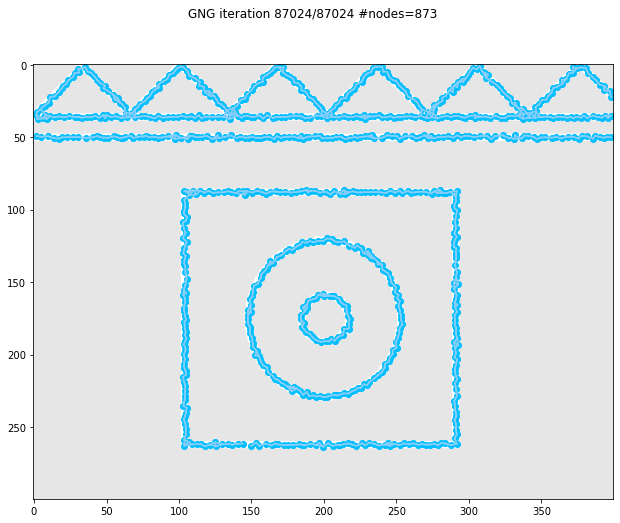

335.8045667000042


In [181]:
start_time = perf_counter()
# gng.learn(binary_img, normalized_data)
gng.learn(binary_img, data, visualize=True, display_iteration=len(data))
print(perf_counter() - start_time)

In [182]:
histories[gng.get_experiment_name()] = gng.history.copy()

In [ ]:
errors = [gng.nodes[i]["error"] for i in gng.nodes]
fig, ax = plt.subplots()
ax.plot(errors)

In [ ]:
gng.history[:5]

In [ ]:
losses = [h["loss"] for h in gng.history]
fig, ax = plt.subplots()
ax.plot(losses)

In [ ]:
times = [h["time"] for h in gng.history]
fig, ax = plt.subplots()
ax.plot(times)

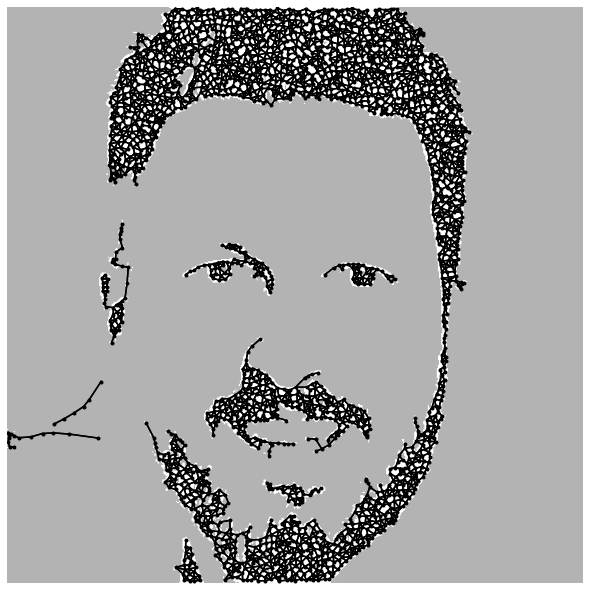

In [126]:
fig = gng.draw_image(figsize=(12, 8), show_node=True, show_image=True)
# plt.text(10, 280, gng.get_experiment_name(), ha='left', wrap=True, size=13)
fig.savefig(f'{img_name}-{gng.get_experiment_name()}.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

In [ ]:
np.max(normalized_data)

In [ ]:
df = []
# binary_img = ~binary_img
for (x, y), val in np.ndenumerate(binary_img):
    if val == False:
        df.append([y, -x])
scale_factor = 0.001   
data = scale_factor * np.array(df)
print("Number of data points: {:,}".format(len(data)))

plt.figure(figsize=(20, 27.5))
plt.scatter(*np.array(data).T / scale_factor, s=3, alpha=1)

# neupy

In [86]:
def create_gng(max_nodes, step=0.2, n_start_nodes=2, max_edge_age=50):
    return algorithms.GrowingNeuralGas(
        n_inputs=2,
        n_start_nodes=n_start_nodes,

        shuffle_data=True,
        verbose=True,

        step=step,
        neighbour_step=0.005,

        max_edge_age=max_edge_age,
        max_nodes=max_nodes,

        n_iter_before_neuron_added=100,
        after_split_error_decay_rate=0.5,
        error_decay_rate=0.995,
        min_distance_for_update=0.01,
    )

In [87]:
def draw_image(graph, show=True):
    for node_1, node_2 in graph.edges:
        weights = np.concatenate([node_1.weight, node_2.weight])
        line, = plt.plot(*weights.T, color='black')
        plt.setp(line, linewidth=0.2, color='black')

    plt.xticks([], [])
    plt.yticks([], [])
    
    if show:
        plt.show()

In [89]:
scale_factor = 1

In [90]:
a = (data / scale_factor)
len(a)

4110

In [91]:
for x, y in a:
    print(x, y)
    break

18.0 284.0


In [92]:
data_img = np.zeros((300, 200))
for x, y in a.astype("int"):
    data_img[-y, x] = 1
data_img = np.logical_not(data_img).astype(int)

IndexError: index -301 is out of bounds for axis 0 with size 300

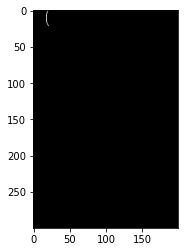

In [95]:
plt.figure()
plt.imshow(data_img, cmap="gray")

In [96]:
np.unique(data_img, return_counts=True)

(array([0., 1.]), array([59978,    22], dtype=int64))

In [97]:
np.unique(data_img, return_counts=True)

(array([0., 1.]), array([59978,    22], dtype=int64))

In [98]:
np.unique(binary_img, return_counts=True)

(array([0., 1.], dtype=float32), array([115890,   4110], dtype=int64))

In [99]:
data[:, 0].min(), data[:, 0].max(), data[:, 1].min(), data[:, 1].max()

(18, 220, 67, 357)

In [120]:
df = []
invert_binary_img = binary_img
for (x, y), val in np.ndenumerate(invert_binary_img):
    if val == False:
        df.append([y, -x])
scale_factor = 1#0.001   
neupy_data = scale_factor * np.array(df)
print("Number of data points: {:,}".format(len(data)))

Number of data points: 4,110


In [124]:
neupy_data = data


Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] train_end_signal = None
[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 50
[OPTION] max_nodes = 2400
[OPTION] min_distance_for_update = 0.01
[OPTION] n_inputs = 2
[OPTION] n_iter_before_neuron_added = 100
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.005
[OPTION] step = 0.2


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           1 |      15.677 |           - |      198 ms |
---------------------------------------------------------



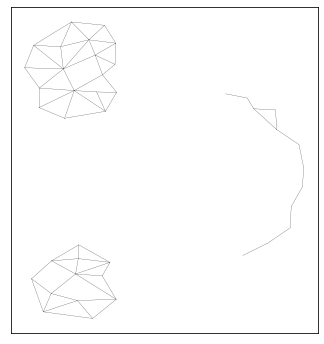


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           2 |      6.8257 |           - |      317 ms |
---------------------------------------------------------



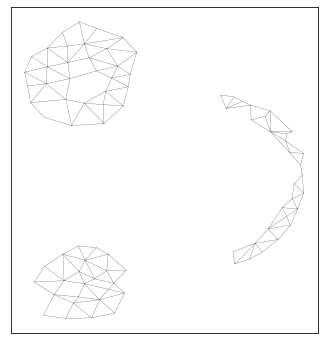


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           3 |      5.1474 |           - |      429 ms |
---------------------------------------------------------



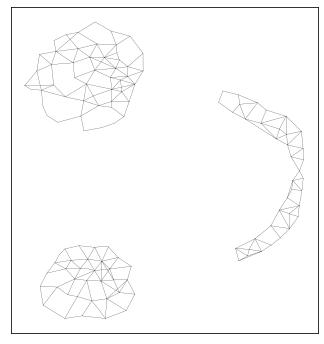


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           4 |      4.1958 |           - |      541 ms |
---------------------------------------------------------



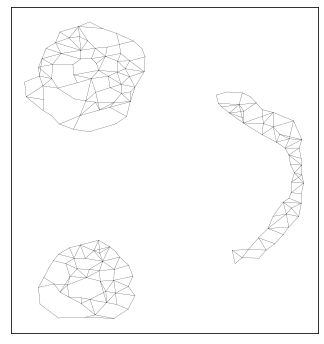


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           5 |       3.632 |           - |      629 ms |
---------------------------------------------------------



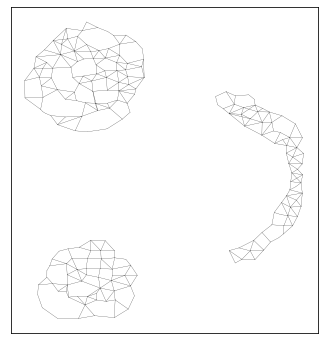


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           6 |      3.2271 |           - |      740 ms |
---------------------------------------------------------



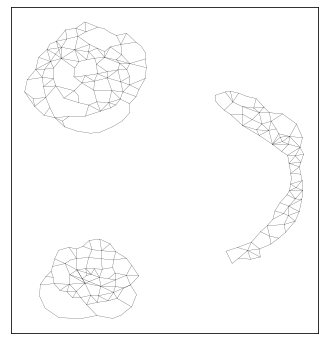


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           7 |      2.9149 |           - |      859 ms |
---------------------------------------------------------



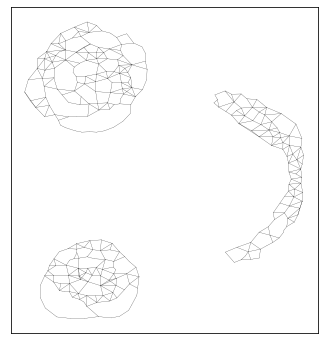


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           8 |      2.6455 |           - |      946 ms |
---------------------------------------------------------



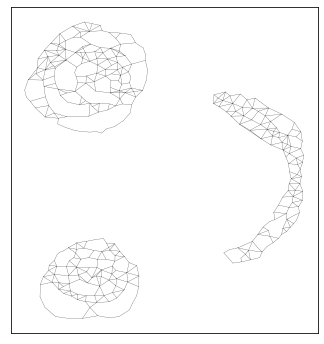


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           9 |       2.426 |           - |       1 sec |
---------------------------------------------------------



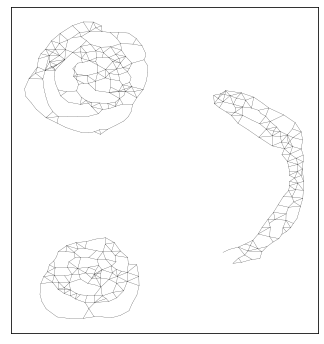


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|          10 |      2.2444 |           - |       1 sec |
---------------------------------------------------------



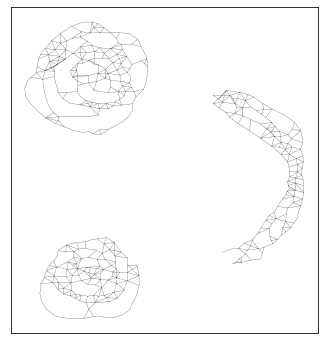


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|          11 |      2.1074 |           - |       1 sec |
---------------------------------------------------------



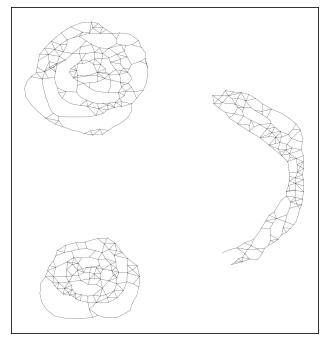


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|          12 |      1.9842 |           - |       1 sec |
---------------------------------------------------------



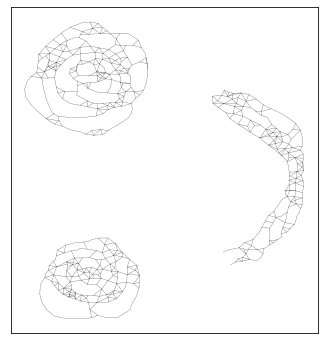


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|          13 |      1.8808 |           - |       1 sec |
---------------------------------------------------------



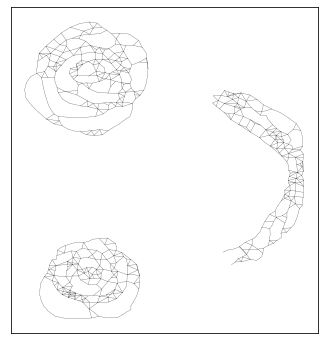


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|          14 |      1.7703 |           - |       1 sec |
---------------------------------------------------------



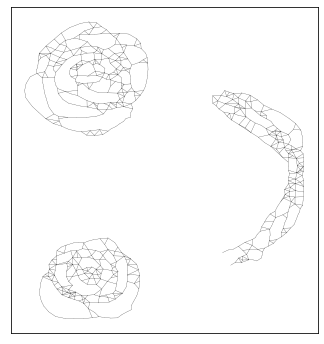


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|          15 |      1.6833 |           - |       1 sec |
---------------------------------------------------------



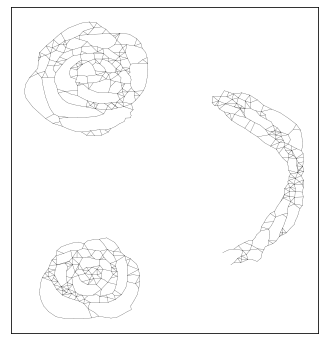


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|          16 |      1.6031 |           - |       1 sec |
---------------------------------------------------------



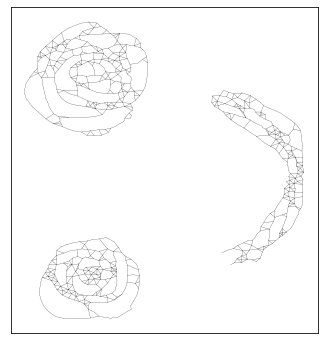


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|          17 |      1.5214 |           - |       1 sec |
---------------------------------------------------------



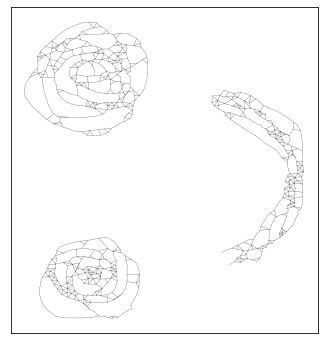


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|          18 |      1.4549 |           - |       1 sec |
---------------------------------------------------------



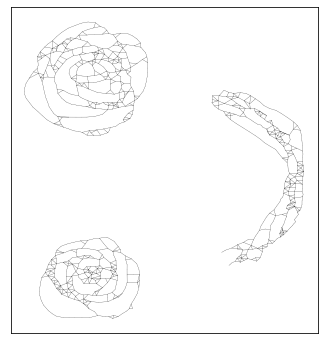


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|          19 |      1.3942 |           - |       2 sec |
---------------------------------------------------------



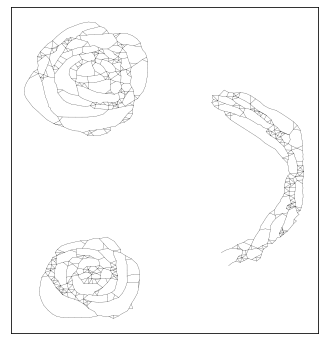


Start training

[TRAINING DATA] shapes: (4110, 2)
[TRAINING] Total epochs: 1

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|          20 |      1.3395 |           - |       2 sec |
---------------------------------------------------------



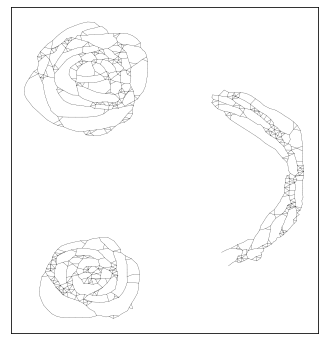

In [125]:
from neupy import algorithms, utils
    
# utils.reproducible()
neupy_gng = create_gng(max_nodes=2400)

for epoch in range(20):
    neupy_gng.train(neupy_data, epochs=1)
    
    # Plot images after each iteration in order to see training progress
    plt.figure(figsize=(5.5, 6))
    draw_image(neupy_gng.graph)